In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pandas as pd
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
sns.set()


In [3]:
from helper import Helper
import plots

In [4]:
helper = Helper()

In [5]:
train = helper.read_csv("../data/train.csv")
test = helper.read_csv("../data/test.csv")

file read as csv
file read as csv


In [6]:
display(train.head())
display(train.describe())
display(train.info())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


None

In [7]:
helper.percent_missing(train)

0.0

In [8]:
def get_feature(df):
    return df[["Date", "Sales"]]

In [9]:
def drop_closed(df):
    df = df[df['Open'] == 1]
    return df

In [10]:
def scaler(df, columns, mode="minmax"):
    if (mode == "minmax"):
        minmax_scaler = MinMaxScaler()
        return pd.DataFrame(minmax_scaler.fit_transform(df), columns=columns), minmax_scaler
    elif (mode == "standard"):
        scaler = StandardScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=columns), scaler
    elif (mode == "robust"):
        scaler = RobustScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=columns), scaler

In [11]:
def add_scaled_sales(df):
    scaled_sales, scaler_obj = scaler(df[["Sales"]], mode="minmax", columns=["scaled_sales"])
    df["scaled_sales"] = scaled_sales["scaled_sales"].to_list()
    return df, scaler_obj

In [12]:
def handle_outliers(df, col, method="lower_upper"):
        
        df = df.copy()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        lower_bound = q1 - ((1.5) * (q3 - q1))
        upper_bound = q3 + ((1.5) * (q3 - q1))

        if method == "mean":
            df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

        elif  method == "mode":
            df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
        else:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

        return df

In [13]:
train["Sales"] = train["Sales"].astype("float")

In [14]:
data = drop_closed(train)
data = get_feature(data)
data = handle_outliers(data, "Sales")


In [15]:
data_agg = data.groupby("Date").agg({"Sales": "mean"})
helper.percent_missing(data_agg)
data_agg.describe()


,Sales
count,942.000000
mean,6988.142162
std,1475.510458
min,4057.782960
25%,5725.756766
50%,6822.535825
75%,7778.867102
max,11908.661883


In [16]:
def check_stationary(df, col):
    adfResult = adfuller(df[col].values, autolag='AIC')
    print(f'ADF Statistic: {adfResult[0]}')
    print(f'p-value: {adfResult[1]}')
    return adfResult[1] >= 0.05

In [17]:
check_stationary(data_agg, "Sales")

ADF Statistic: -4.7192713993360185
p-value: 7.741088433521508e-05


False

In [18]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [19]:
def corrPlots(array: np.array, is_partial=False):
    plt.figure(figsize=(30, 5))
#     plt.title(title)
#     plt.bar(range(len(array)), array)
#     plt.grid(True)
    if (not is_partial):
        plot_acf(array)
    else:
        plot_pacf(array)
    plt.show()

<Figure size 2160x360 with 0 Axes>

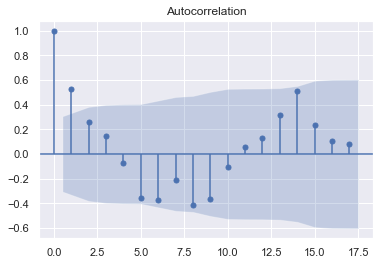

In [20]:
acfSalesScaled = acf(data_agg["Sales"].values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)
corrPlots(acfSalesScaledNp)

<Figure size 2160x360 with 0 Axes>

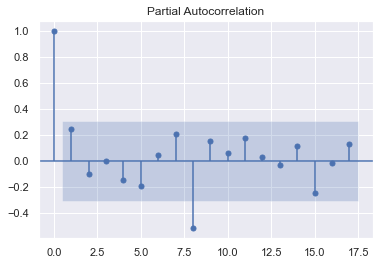

In [21]:
pacfSalesScaled = pacf(data_agg["Sales"].values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, is_partial=True)

In [22]:
scaled_df, scaler_obj = add_scaled_sales(data_agg)
data_agg["Sales"].isna().any().sum()



0

In [23]:
class TimeSeriesSalsesPred:
    
    def __init__(self, WINDOW_SIZE, BATCH_SIZE, sales_data):
        self.WINDOW_SIZE = WINDOW_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        
        data_agg = sales_data.groupby("Date").agg({"Sales": "mean"})
        self.SIZE = len(data_agg["Sales"])

        self.scaled_df, self.scaler_obj = add_scaled_sales(data_agg)
        
        self.DateTrain = np.reshape(self.scaled_df.index.values[0:BATCH_SIZE], (-1, 1))
        self.DateValid = np.reshape(self.scaled_df.index.values[BATCH_SIZE:], (-1, 1))
        
        self.train_sales, self.valid_sales, self.TrainDataset, self.ValidDataset = self.prepare_data(WINDOW_SIZE,
                                                                                                     BATCH_SIZE, 
                                                                                                     self.scaled_df)
    
    def prepare_data(self, WINDOW_SIZE, BATCH_SIZE, scaled_df):
        train_sales = scaled_df["scaled_sales"].values[0:BATCH_SIZE].astype('float32')
        valid_sales = scaled_df["scaled_sales"].values[BATCH_SIZE:].astype('float32')
        TrainDataset = self.windowed_dataset(train_sales, WINDOW_SIZE, BATCH_SIZE)
        ValidDataset = self.windowed_dataset(valid_sales, WINDOW_SIZE, BATCH_SIZE)
        
        return train_sales, valid_sales, TrainDataset, ValidDataset
    
    def train(self, EPOCHS, verbose=1, ):
        model = Sequential()
        model.add(LSTM(20, input_shape=[None, 1], return_sequences=True))
        model.add(LSTM(10, input_shape=[None, 1]))
        model.add(Dense(1))
        model.compile(loss="huber_loss", optimizer='adam')
        model.summary()
        
        history = model.fit(self.TrainDataset, epochs=EPOCHS, validation_data=self.ValidDataset, verbose=verbose)
        
        self.plot_history(history)
        
        
        return model, history
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(12, 9))
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="val_loss")
        plt.legend()
        plt.show()
        
        return fig
    
   
    def model_forecast_test(self, model):

        series = self.scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(self.WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(self.WINDOW_SIZE))
        ds = ds.batch(self.SIZE).prefetch(1)
        forecast = model.predict(ds)
        
        Results = forecast[self.BATCH_SIZE-self.WINDOW_SIZE:-1]
        Results1 = self.scaler_obj.inverse_transform(Results.reshape(-1,1))
        XValid1 = self.scaler_obj.inverse_transform(self.valid_sales.reshape(-1,1))
        
        fig, MAE, RMSE = self.plot_forcast(Results, Results1, XValid1, self.DateValid, self.WINDOW_SIZE)
        
        
        return forecast, fig, MAE, RMSE
    
    def plot_forcast(self, Results, Results1, XValid1, DateValid,  WINDOW_SIZE):
        fig = plt.figure(figsize=(30, 8))
        plt.title("LSTM Model Forecast Compared to Validation Data")
        
        plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
        plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
        
        plt.xlabel('Date')
        plt.ylabel('Thousands of Units')
        plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
        plt.legend(loc="upper right")

        MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
        RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

        textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

        # place a text box in upper left in axes coords
        plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
        plt.grid(True)

        plt.show()
        
        return fig, MAE, RMSE
    
        
        

    
    def windowed_dataset(self, series, window_size, batch_size): 
        series = tf.expand_dims(series, axis=-1)
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

        
        

In [24]:
SIZE = len(data_agg["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 400

t = TimeSeriesSalsesPred(WINDOW_SIZE, BATCH_SIZE, data)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] 0.103 - 6s 6s/step - loss: 0.1031 - val_loss: 0.0877
Epoch 2/400
1/1 [==============================] - ETA: 0s - loss: 0.088 - 0s 476ms/step - loss: 0.0887 - val_loss: 0.0748
Epoch 3/400
1/1 [==============================] - ETA: 0s - loss: 0.075 - 0s 351ms/step - loss: 0.0759 - val_loss: 0.0632
Epoch 4/400
1/1 [===================

1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 320ms/step - loss: 0.0180 - val_loss: 0.0149
Epoch 62/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 297ms/step - loss: 0.0180 - val_loss: 0.0150
Epoch 63/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 287ms/step - loss: 0.0180 - val_loss: 0.0150
Epoch 64/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 314ms/step - loss: 0.0180 - val_loss: 0.0150
Epoch 65/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 290ms/step - loss: 0.0180 - val_loss: 0.0150
Epoch 66/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 271ms/step - loss: 0.0181 - val_loss: 0.0150
Epoch 67/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 287ms/step - loss: 0.0181 - val_loss: 0.0150
Epoch 68/400
1/1 [==============================] - ETA: 0s - loss: 0.018 - 0s 283ms/step - loss: 0.0180 - val_loss: 0.0150
Epoch 69/400
1/1 [===

Epoch 127/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 251ms/step - loss: 0.0179 - val_loss: 0.0148
Epoch 128/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 258ms/step - loss: 0.0179 - val_loss: 0.0147
Epoch 129/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 299ms/step - loss: 0.0179 - val_loss: 0.0147
Epoch 130/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 274ms/step - loss: 0.0179 - val_loss: 0.0147
Epoch 131/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 1s 692ms/step - loss: 0.0178 - val_loss: 0.0147
Epoch 132/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 306ms/step - loss: 0.0178 - val_loss: 0.0147
Epoch 133/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 265ms/step - loss: 0.0178 - val_loss: 0.0147
Epoch 134/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 271ms/step - loss: 0.0178 - val_loss: 0.0147


1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 284ms/step - loss: 0.0176 - val_loss: 0.0145
Epoch 193/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 323ms/step - loss: 0.0176 - val_loss: 0.0145
Epoch 194/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 271ms/step - loss: 0.0176 - val_loss: 0.0145
Epoch 195/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 281ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 196/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 261ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 197/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 292ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 198/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 290ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 199/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 301ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 200/400


Epoch 258/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 409ms/step - loss: 0.0170 - val_loss: 0.0136
Epoch 259/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 282ms/step - loss: 0.0170 - val_loss: 0.0135
Epoch 260/400
1/1 [==============================] - ETA: 0s - loss: 0.017 - 0s 327ms/step - loss: 0.0170 - val_loss: 0.0135
Epoch 261/400
1/1 [==============================] - ETA: 0s - loss: 0.016 - 0s 336ms/step - loss: 0.0169 - val_loss: 0.0135
Epoch 262/400
1/1 [==============================] - ETA: 0s - loss: 0.016 - 0s 293ms/step - loss: 0.0169 - val_loss: 0.0134
Epoch 263/400
1/1 [==============================] - ETA: 0s - loss: 0.016 - 0s 276ms/step - loss: 0.0169 - val_loss: 0.0134
Epoch 264/400
1/1 [==============================] - ETA: 0s - loss: 0.016 - 0s 267ms/step - loss: 0.0169 - val_loss: 0.0134
Epoch 265/400
1/1 [==============================] - ETA: 0s - loss: 0.016 - 0s 285ms/step - loss: 0.0169 - val_loss: 0.0133


1/1 [==============================] - ETA: 0s - loss: 0.014 - 0s 262ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 324/400
1/1 [==============================] - ETA: 0s - loss: 0.014 - 0s 259ms/step - loss: 0.0142 - val_loss: 0.0096
Epoch 325/400
1/1 [==============================] - ETA: 0s - loss: 0.014 - 0s 330ms/step - loss: 0.0141 - val_loss: 0.0094
Epoch 326/400
1/1 [==============================] - ETA: 0s - loss: 0.014 - 0s 261ms/step - loss: 0.0140 - val_loss: 0.0092
Epoch 327/400
1/1 [==============================] - ETA: 0s - loss: 0.013 - 0s 267ms/step - loss: 0.0139 - val_loss: 0.0090
Epoch 328/400
1/1 [==============================] - ETA: 0s - loss: 0.013 - 0s 267ms/step - loss: 0.0138 - val_loss: 0.0088
Epoch 329/400
1/1 [==============================] - ETA: 0s - loss: 0.013 - 0s 261ms/step - loss: 0.0137 - val_loss: 0.0086
Epoch 330/400
1/1 [==============================] - ETA: 0s - loss: 0.013 - 0s 260ms/step - loss: 0.0136 - val_loss: 0.0085
Epoch 331/400


Epoch 389/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 309ms/step - loss: 0.0125 - val_loss: 0.0077
Epoch 390/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 272ms/step - loss: 0.0125 - val_loss: 0.0077
Epoch 391/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 288ms/step - loss: 0.0125 - val_loss: 0.0077
Epoch 392/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 295ms/step - loss: 0.0125 - val_loss: 0.0077
Epoch 393/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 279ms/step - loss: 0.0125 - val_loss: 0.0076
Epoch 394/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 286ms/step - loss: 0.0125 - val_loss: 0.0076
Epoch 395/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 282ms/step - loss: 0.0125 - val_loss: 0.0076
Epoch 396/400
1/1 [==============================] - ETA: 0s - loss: 0.012 - 0s 352ms/step - loss: 0.0125 - val_loss: 0.0076


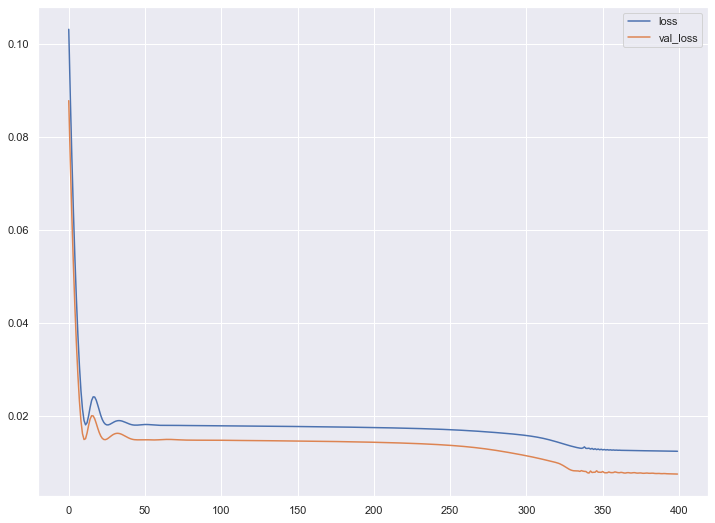

In [25]:
model1, his = t.train(EPOCHS)

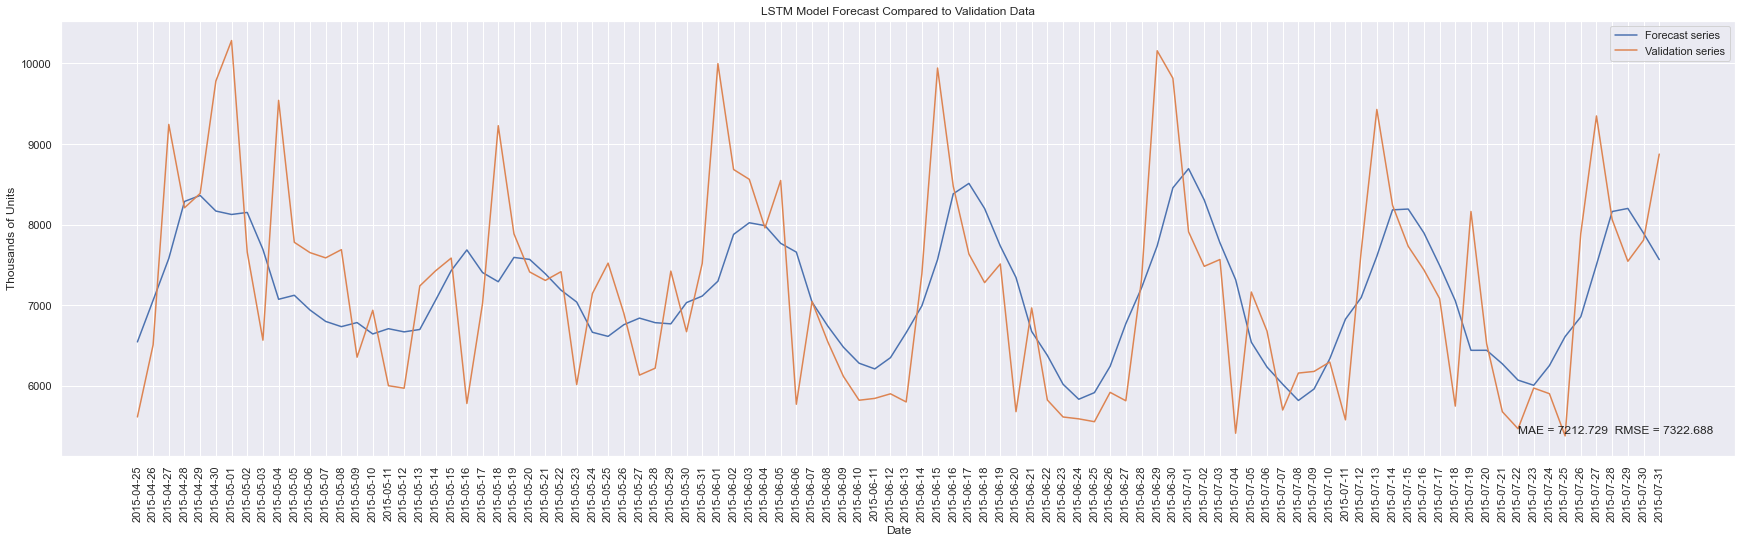

In [26]:
forecast, fig, MAE, RMSE = t.model_forecast_test(model1)

In [27]:
def forcast_next_one_sale(model, sales):
    data_feat = None
    WINDOW_SIZE = 49
    try:
        data_feat = sales[["Sales", "Date"]]
        
        if (data_feat.shape[0] < 49):
            print("To make prediction, we need atleast data of 49 dates")
            return
        scaled_df, scaler_obj = add_scaled_sales(data_feat)
        data_feat["Sales"].isna().any().sum()
        SIZE = len(data_agg["Sales"])
        
        
        series = scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE))
        ds = ds.batch(SIZE).prefetch(1)
        
        forecast = model.predict(ds)
        Results = list(forecast.reshape(1, forecast.shape[0] * forecast.shape[1])[0].copy())

        Results1 = scaler_obj.inverse_transform(forecast.reshape(-1,1))
        Results1 = list(Results1.reshape(1, Results1.shape[0] * Results1.shape[1])[0])
        
    

        
        return  Results1, Results
        
    except KeyError:
        print("Sales Data is expeceted to have Sales and Date columns")
        return False
        
        

def forcast_next_sales(model, sales, daysToForcast=1):
    forcasts = []
    scaled_forcasts = []
    dates = []
    
    new_sales_df = sales.copy()
    while len(forcasts) < daysToForcast:
        forcast, scaled_forcast = forcast_next_one_sale(model1, new_sales_df)
        forcasts += forcast
        
        scaled_forcasts += scaled_forcast
        size=len(new_sales_df["Sales"])
        
        truncated_sales = new_sales_df.tail(size - len(scaled_forcast))
                
        new_sales = truncated_sales['Sales'].to_list() + scaled_forcast
        next_dates = []
        
        for i in range(len(scaled_forcast)):
            next_date = new_sales_df["Date"].to_list()[-1] + datetime.timedelta(days=1)
            next_dates.append(next_date)     
        
        new_dates = truncated_sales['Date'].to_list() + next_dates
        new_sales_df = pd.DataFrame()
        new_sales_df["Date"] = new_dates
        new_sales_df["Sales"] = new_sales
    
    res_df = pd.DataFrame()
    res_df["Date"] = new_dates
    res_df["forcasts"] = forcasts
    
    return res_df
        
        
        
        
    
    

In [28]:
data_agg["Date"] = data_agg.index
data_agg["Date"] = data_agg["Date"].astype("datetime64")
res_df = forcast_next_sales(model1, data_agg.head(49), 49)
res_df

,Date,forcasts
0,2013-02-19,7977.993164
1,2013-02-20,4596.874512
2,2013-02-21,3449.899170
3,2013-02-22,2463.396484
4,2013-02-23,1855.750977
5,2013-02-24,1915.843506
6,2013-02-25,2642.866211
7,2013-02-26,3658.981689
8,2013-02-27,4692.130859
9,2013-02-28,5323.604980


In [29]:
model1.save("../models/lstm_sales_pred_model.h5")